<h1> B Data Reduction </h1>

# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np
import warnings
import statistics as stt
import os
from scipy import stats
from scipy.optimize import curve_fit
from numpy import arange
from collections import deque
import string
import math
from pyrolite.plot import pyroplot

# Functions

In [2]:
#-------------------------------
# Loading & select different type of data, z.b B, C, U
#-------------------------------

def dirFiles(fDir, ending):
    fNames = []
    for i in os.listdir(fDir):
        if i.endswith(ending):
            fNames.append(i)
    return fNames

#-------------------------------
# used for mapping
#-------------------------------

def selSmpType(dataFiles):
    l = []
    for file in dataFiles:    
        l.append(float(file.split('_')[0]))
    return l

#-------------------------------
# Outlier Correction and Data Conversion from str to float
#-------------------------------
def outlierCorrection(data, factorSD):
    element_signal = np.array(data)
    mean = np.mean(element_signal, axis=0)
    sd = np.std(element_signal, axis=0)
    return [x for x in data if (x > mean - factorSD * sd) and (x < mean + factorSD * sd)]

#-------------------------------
# background substact for 10B with the average of 9.9 and 10.2, think abut each line has to be connected
#-------------------------------

def bacground_sub(folder, select_line, factorSD, factor_B11):
    listname = dirFiles('/Users/mila/Documents/GitHub/boron-main/data/' + folder, 'exp')
    listname.sort()
    average_B = []
    for filename in listname:
        #read data
        df = pd.read_csv('/Users/mila/Documents/GitHub/boron-main/data/' +folder + '/' +filename, sep='\t', header=22)  # Hi Jie, I already inserted the additional argument here
        #read all data rows and select useful columns
        fil = df['10B'].str.contains('L|IC|C|H') == True
        endnum = df['10B'][fil].index[0]
        df_data = df[:endnum][['9.9', '10B', '10.2', '11B']].astype(float)
            #seperate two dataframe based on selectline, one is background, one is signal 
        index_select = df_data['10B'] >= select_line
        df_bacground_mean = df_data[~index_select].mean()
        df_signal = df_data.loc[index_select]
            #substract background, substract bulc for 10B and 11B
        df_bacground_sub = df_signal - df_bacground_mean
        df_bacground_sub['10B_bulc_sub'] = df_bacground_sub['10B']-(df_bacground_sub['9.9']+df_bacground_sub['10.2'])/2
        df_bacground_sub['11B_bulc_sub'] = df_bacground_sub['11B']-factor_B11*(df_bacground_sub['9.9']+df_bacground_sub['10.2'])/2
        df_bacground_sub['11B/10B'] = df_bacground_sub['11B_bulc_sub']/df_bacground_sub['10B_bulc_sub'] 

        res_iso = outlierCorrection(df_bacground_sub['11B/10B'], factorSD)
        res_11B = outlierCorrection(df_bacground_sub['11B'], factorSD)
        average_B.append({'filename': filename, '11B': np.mean(res_11B), '11B/10B_row': np.mean(res_iso), 'se': np.std(res_iso)/math.sqrt(len(res_iso))})
    return (pd.DataFrame(average_B))


#-------------------------------
# regression based on the level from 2-5 you chosed
#-------------------------------

def polynomFit(inp, *args):
    x=inp
    res=0
    for order in range(len(args)):
        res+=args[order] * x**order
    return res


def regression(x, y, ref_stand, order, listname):
    fig, ax = plt.subplots()
    ax.plot(x, y, label='measuered', marker='o', linestyle='none' )
    x_use = np.array(x)
    popt, pcov = curve_fit(polynomFit, xdata=x_use, ydata=y , p0=[0]*(order+1))
    fitData=polynomFit(x_use,*popt)
    ax.plot(x_use, fitData, label='polyn. fit, order '+str(order), linestyle='--' )
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    res = []
    for unknown in listname:
        y_unknown = ref_stand / polynomFit(unknown,*popt)
        res.append({'factor': y_unknown})
    return(pd.DataFrame(res))


#-------------------------------
# data from machine for trace elements couldn't be used directly for plotting or calculation
## delete repete Ca44 and Mg26 data, unify the formate of column titles, and float all str data.
#-------------------------------

def prepare_trace(datafile):
    if 'LR' in datafile.columns[14]:
        del datafile['44Ca(LR)']
        del datafile['26Mg(LR)']
    else:
        del datafile['44Ca']
        del datafile['26Mg']
    
    datafile.columns = datafile.columns.str.replace('\d+', '')
    datafile.columns = datafile.columns.str.replace('\('+'LR'+'\)', '')
    res = []
    for i in range(13, len(datafile.columns)):
        for j in datafile.iloc[:, i]:
            if '<' in j:
                res.append(j)
    RES = datafile.replace(to_replace = res, value='nan', regex=True)
    RES2 = RES.replace({'ERROR: Error (#1002): Internal standard composition can not be 0': np.nan})
    RES3 = RES2.replace({'ERROR: Error (#1003): Calibration RM composition does not contain analyte element': np.nan})
    RES4 = RES3.iloc[:, 13:].astype(float)
    columns = RES4.iloc[:, 13:].columns
    RES4[columns] = RES4.iloc[:, 13:]
    RES4[' Sequence Number'] = RES3['LB#']
    return(RES4)

# machine drift correction and isotope results calculations

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


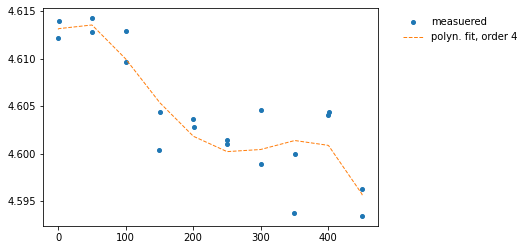

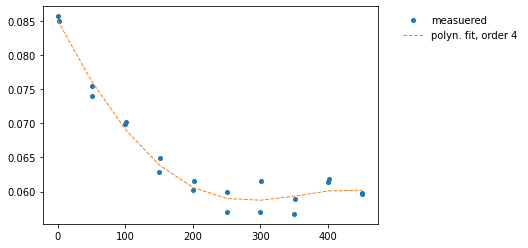

In [3]:
#background substraction
df_data = bacground_sub('2022-11-28 B Carb Sy MC JX AG splitstream_20221128-203622', 0.01, 1.5, 1)
#Choose A/B/C/D/U to get the regression for drift correction
sample_correction = 'A'

fil = df_data['filename'].str.contains(sample_correction)
df_data_B = df_data[fil]
df_data[' Sequence Number'] = selSmpType(df_data['filename'])

y_isotope = df_data_B['11B/10B_row']
y_11B = df_data_B['11B']
x = df_data_B.index.to_numpy()
#get the regression function and get all corrected factors for all measurements
factor_iso = regression(x,y_isotope, 4.05, 4, df_data.index.to_numpy())
factor_B = regression(x,y_11B, 35, 4, df_data.index.to_numpy())


#use corrected factors to correct machine drift and calculate isotope values for results
df_data['factor_iso'] = factor_iso
df_data['factor_B'] = factor_B

df_data['11B/10B_corrected'] = df_data['factor_iso']*df_data['11B/10B_row']
df_data['δ11B'] = ((df_data['11B/10B_corrected']/4.055)-1)*1000
df_data['δ11B_se'] = (df_data['se']*df_data['factor_iso']/4.055)*1000

# Mapping: Laser parameters and isotope results

In [4]:
#read laser file
df_Laser = pd.read_csv('/Users/mila/Documents/GitHub/boron-main/data/seq1_log_20221128_203700.csv', header=0)
#reorganize the laser file since many rows are wrong and useless
#df_Laser = pd.read_csv('data/seq1_log_20221128_203700.csv', header=0)
df_Laser_part1 = df_Laser[df_Laser[' Laser State'] == 'On'].iloc[:, [13, 20, 21]]
df_Laser_part2 = df_Laser[df_Laser[' Sequence Number'].notnull()].iloc[:, [1, 4]]

df_Laser_res = pd.concat([df_Laser_part2.reset_index(drop=True), df_Laser_part1.reset_index(drop=True)], axis=1)
#merge laser data and neptune data
  

In [6]:
df_map1 = df_Laser_res.merge(df_data,on=' Sequence Number')
df_map1


,Sequence Number,Comment,Spot Size (um),Laser HV (kV),Laser Energy (mJ)
0,1.0,NIST nnp,193.0,24.51,73.30
1,2.0,NIST nnp,193.0,24.55,76.26
2,3.0,B5 nnP,285.0,24.57,76.96
3,4.0,B5 nnP,285.0,24.65,76.10
4,5.0,MACS,193.0,24.58,76.62
...,...,...,...,...,...
469,470.0,NaN,130.0,24.50,75.77
470,471.0,NaN,130.0,24.48,76.37
471,472.0,NaN,130.0,24.50,75.23
472,473.0,NaN,130.0,24.49,76.61


In [25]:
s = []
for i in df_data['filename']: 
    s.append(int(i.split('_')[0]))
df_data['number'] = s
df_data

,filename,11B,11B/10B_row,se,Sequence Number,factor_iso,factor_B,11B/10B_corrected,δ11B,δ11B_se,number
0,001_A.exp,0.085670,4.612142,0.000937,1.0,0.877937,411.888999,4.049171,-1.437467,0.202893,1
1,002_A.exp,0.084994,4.613930,0.000892,2.0,0.877923,412.820451,4.050677,-1.066193,0.193209,2
2,003_B.exp,0.081583,4.585416,0.000957,3.0,0.877910,413.753258,4.025582,-7.254625,0.207142,3
3,004_B.exp,0.092706,4.584921,0.000728,4.0,0.877897,414.687396,4.025090,-7.376009,0.157695,4
4,005_C.exp,0.064789,4.583214,0.001079,5.0,0.877885,415.622840,4.023536,-7.759228,0.233650,5
...,...,...,...,...,...,...,...,...,...,...,...
469,470_U.exp,0.076025,4.594739,0.000852,470.0,0.882004,584.583906,4.052578,-0.597275,0.185425,470
470,471_U.exp,0.070070,4.602693,0.000994,471.0,0.882052,584.826288,4.059813,1.187042,0.216171,471
471,472_U.exp,0.070474,4.601038,0.000962,472.0,0.882101,585.076943,4.058579,0.882590,0.209287,472
472,473_U.exp,0.072482,4.600263,0.000893,473.0,0.882150,585.335981,4.058123,0.770141,0.194353,473


# Calculate B concentration from signal intensity of Neptune

In [43]:
#sample_correction
ref = ((df_map1[df_map1['filename'].str.contains(sample_correction)][' Spot Size (um)']/2)**2).mean()
#define the depth ratio
depth_ref = 30
depth_sample = 30
depth_ratio = depth_sample/depth_ref
#use spot diameter, depth and signal intensity to calculate [B]
df_map1['[B]_corrected'] =  df_map1['11B']*df_map1['factor_B'] * (ref / ((df_map1[' Spot Size (um)']/2)**2) / depth_ratio)

# Mapping:  isotope results and trace elements

In [44]:
df_trace = prepare_trace(pd.read_csv('/Users/mila/Documents/博士论文/实验数据/trace elements/2022-11-28 TREE Hallmann Sy MC JX AG/results/code/2022-11-28-Si-NISTnnp.csv'))

df_all = df_map1.merge(df_trace,on=' Sequence Number')
#df_all.to_csv('final.csv')
df_all

/var/folders/7h/d1qc3x117419gw0q21cgm7z00000gn/T/ipykernel_33855/1995825519.py:103: FutureWarning: The default value of regex will change from True to False in a future version.
  datafile.columns = datafile.columns.str.replace('\d+', '')
/var/folders/7h/d1qc3x117419gw0q21cgm7z00000gn/T/ipykernel_33855/1995825519.py:104: FutureWarning: The default value of regex will change from True to False in a future version.
  datafile.columns = datafile.columns.str.replace('\('+'LR'+'\)', '')


,Sequence Number,Comment,Spot Size (um),Laser HV (kV),Laser Energy (mJ),filename,11B,11B/10B_row,se,factor_iso,...,Er,Tm,Yb,Lu,Hf,Tl,Pb,Bi,Th,U
0,1.0,NIST nnp,193.0,24.51,73.30,001_A.exp,0.085670,4.612142,0.000937,0.877937,...,37.147949,35.659813,38.163741,35.957030,35.784769,14.788083,38.600806,30.140200,36.609571,37.061966
1,2.0,NIST nnp,193.0,24.55,76.26,002_A.exp,0.084994,4.613930,0.000892,0.877923,...,38.883298,37.973611,40.272228,37.885513,37.643420,15.019810,38.542372,30.258338,38.828629,37.711082
2,3.0,B5 nnP,285.0,24.57,76.96,003_B.exp,0.081583,4.585416,0.000957,0.877910,...,2.713400,0.347026,2.314674,0.319976,4.315975,0.071269,7.254856,0.019236,7.458843,2.231423
3,4.0,B5 nnP,285.0,24.65,76.10,004_B.exp,0.092706,4.584921,0.000728,0.877897,...,3.013857,0.387108,2.550793,0.360716,4.878254,0.084123,7.431691,0.023003,8.088325,2.338008
4,5.0,MACS,193.0,24.58,76.62,005_C.exp,0.064789,4.583214,0.001079,0.877885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,470.0,NaN,130.0,24.50,75.77,470_U.exp,0.076025,4.594739,0.000852,0.882004,...,44.138185,42.299274,45.301446,42.840980,38.869490,15.704012,40.782685,31.601976,42.087428,39.226180
470,471.0,NaN,130.0,24.48,76.37,471_U.exp,0.070070,4.602693,0.000994,0.882052,...,44.820343,43.365967,45.894008,43.177703,39.407686,16.387488,38.973840,32.812162,42.705030,39.617627
471,472.0,NaN,130.0,24.50,75.23,472_U.exp,0.070474,4.601038,0.000962,0.882101,...,45.293296,43.341192,46.309496,43.701451,40.222120,16.561706,39.210644,32.543793,42.706308,39.465549
472,473.0,NaN,130.0,24.49,76.61,473_U.exp,0.072482,4.600263,0.000893,0.882150,...,44.552121,42.142883,44.539697,42.764981,38.670861,15.672936,39.123892,30.335384,41.911304,39.232311


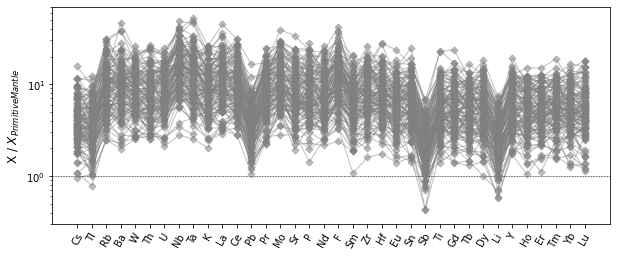

pandas.core.frame.DataFrame

In [66]:
from pyrolite.util.synthetic import example_spider_data

normdf = example_spider_data(start="EMORB_SM89", norm_to="PM_PON")

#normdf = df_all(norm_to="PM_PON")
import pyrolite.plot

ax = normdf.pyroplot.spider(color="0.5", alpha=0.5, unity_line=True, figsize=(10, 4))
ax.set_ylabel("X / $X_{Primitive Mantle}$")
plt.show()

type(normdf)

In [23]:
for i in range(len(df_all.index)):
    if df_all.iloc[i:]['filename'].str.contains('A'):
        res = 1
    else:
        res = 2

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [5]:
data = df_all.loc[1:3]

plt.errorbar(data['B'], data['δ11B'], yerr = data['δ11B_se'], 
            fmt="o", markersize='20', markeredgecolor="black")

NameError: name 'df_all' is not defined

,Rb,Ba,Th,U,La,Ce,Pb,Pr,B,Nd,...,Gd,Tb,Dy,Ho,Er,Y,Tm,Yb,Li,Lu
1,31.360517,40.015193,38.828629,37.711082,36.936944,39.795775,38.542372,38.502871,34.017295,36.165764,...,38.170400,38.795513,36.499707,39.644791,38.883298,39.710578,37.973611,40.272228,40.955399,37.885513
2,61.673738,647.715077,7.458843,2.231423,57.975306,88.528701,7.254856,13.284440,10.168947,52.711187,...,8.130663,1.067271,5.772258,1.044117,2.713400,25.735122,0.347026,2.314674,8.492678,0.319976
3,51.736397,696.732282,8.088325,2.338008,61.603692,91.959657,7.431691,13.816795,10.677247,56.692124,...,9.031403,1.182714,6.478343,1.157381,3.013857,28.421618,0.387108,2.550793,9.228174,0.360716


In [178]:
ree = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
spiderree = ['Cs', 'Rb', 'Ba', 'Th', 'U', 'Nb', 'Ta', 'La', 'Ce', 'Pb', 'Pr', 'B', 'Nd', 'Sr', 'Sm', 'Zr', 'Hf', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Y', 'Tm', 'Yb', 'Li', 'Lu']
dfChondrites = pd.read_excel("/Users/mila/Documents/博士论文/写论文/milling balls/discussion-milling balls/data/chondrite element abundances_test.xlsx")

Text(0, 0.5, 'sample / Primitive mantle')

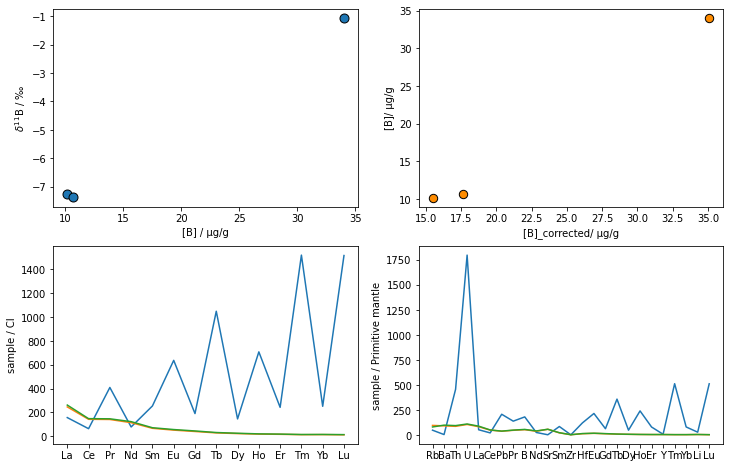

In [240]:
ree = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
spiderree = ['Cs', 'Rb', 'Ba', 'Th', 'U', 'Nb', 'Ta', 'La', 'Ce', 'Pb', 'Pr', 'B', 'Nd', 'Sr', 'Sm', 'Zr', 'Hf', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Y', 'Tm', 'Yb', 'Li', 'Lu']
dfChondrites = pd.read_excel("/Users/mila/Documents/GitHub/boron-main/data/chondrite element abundances_test.xlsx")

fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(12,8))

ree_use = [item for item in ree if item in data.columns.tolist()]   

spiderree_use = [item for item in spiderree if item in data.columns.tolist()]   
cIValues = dfChondrites.loc[3, ree_use].tolist()
cIValuesspider = dfChondrites.loc[0, spiderree_use].tolist()

start_num = 1
end_num = 3

data = df_all.loc[start_num:end_num]

ree_res = data[ree_use]/cIValues
spider_res = data[spiderree_use]/cIValuesspider

ax1.errorbar(data['B'], data['δ11B'], yerr = data['δ11B_se'], 
            fmt="o", markersize='9', markeredgecolor="black")
ax1.set_ylabel('$δ^{11}$B / ‰')
ax1.set_xlabel('[B] / μg/g')
ax2.scatter(data['[B]_corrected'],data['B'], s =70, c = 'darkorange', edgecolors = 'black')
ax2.set_ylabel('[B]/ μg/g')
ax2.set_xlabel('[B]_corrected/ μg/g')
ax3.plot(ree_res.T)
ax4.plot(spider_res.T)
ax3.set_ylabel('sample / CI')
ax4.set_ylabel('sample / Primitive mantle')   

In [ ]:
def plotREE(mean_value, sample):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)
    
    fil_ref = df_all.loc[1:3]
    
    cIValuesspider = dfChondrites.iloc[91:119, 0].tolist()
    
    for i, color,labels in zip(datalist, colors, labelss):
        fil = i['Sample'] == sample
        
        ree_use = [item for item in ree if item in i.columns.tolist()]        
        cIValues = dfChondrites.loc[3, ree_use].tolist()
        spiderree_use = [item for item in spiderree if item in i.columns.tolist()]   
        cIValuesspider = dfChondrites.loc[0, spiderree_use].tolist()

        df_ree = i.loc[fil, ree_use]
        df_spider = i.loc[fil, spiderree_use]
        
        
        ree_ref_res = (df_refs.loc[fil_ref, ree_use])/cIValues
        spider_ref_res = (df_refs.loc[fil_ref, spiderree_use])/cIValuesspider      
        
        ree_res = df_ree/cIValues        
        spider_res = df_spider/cIValuesspider    
               
        ax1.plot(ree_res.T, c=color, label = labels)
        ax2.plot(spider_res.T, c=color, label = labels)
        
        ax1.plot(ree_ref_res.T, c='red')
        ax2.plot(spider_ref_res.T, c='red')
    ax1.set_yscale('log')
    #ax1.set_ylim(10,100)

    ax2.set_yscale('log')
    #ax2.set_ylim(1,100)
    ax1.set_ylabel('sample / CI')
    ax2.set_ylabel('sample / Primitive mantle')        
    ax1.legend()
colors = ['orange', 'pink', 'blue', 'limegreen']
samples = df_Si_np['Sample'].drop_duplicates().dropna()
#, 'yellowgreen', 'darkorchid', 'limegreen', 'skyblue', 'blue', 'deeppink', 'goldenrod')
labelss = ['np_Si', 'np_Ca', 'B5_Si', 'B5_Ca']

# Testing

In [8]:
results = {'Laser Energy (mJ)': res_energy, 
           'Spot Size (um)': res_spotsize, 'Laser HV (kV)': res_HV}

Laser_res= pd.DataFrame(results)
resss = pd.concat([Laser_res, dfN.reindex(Laser_res.index)], axis=1)

NameError: name 'res_energy' is not defined

In [14]:
def laser_Cond(smp):
    return resss[resss['sequence'].str.contains(smp)]

laser_Cond('A')

NameError: name 'resss' is not defined

### Some old code

In [ ]:
#check for outliers for signal:
    element_signal = np.array(fils)
    mean = np.mean(element_signal, axis=0)
    sd = np.std(element_signal, axis=0)
    final_list_signal = [x for x in fils if (x > mean - factorSD * sd)]
    final_list_signal = [x for x in final_list_signal if (x < mean + factorSD * sd)]
    
#check for outliers for background:
    element_backg = np.array(filw)
    mean = np.mean(element_backg, axis=0)
    sd = np.std(element_backg, axis=0)
    final_list_backg = [x for x in filw if (x > mean - factorSD * sd)]
    final_list_backg = [x for x in final_list_backg if (x < mean + factorSD * sd)]
    

def calculateSingleFile(filename, bg_10B, factorSD):
#upload data:
    df = pd.read_csv('data/2022-02-15 Boron measurements/' + filename, sep='\t', header=22)  # Hi Jie, I already inserted the additional argument here
#calculate average signal and average backgroud:
    endnum = df['10B'][df['10B'] == 'L3'].index[0]
#    B_10 = []
    fils = []
    filw = []
#    for i in df['10B'][0:endnum]:
#        B_10.append(float(i)) #conversion to float required, as numbers are stored as str
#    for i in B_10:
    for i in df['10B'][0:endnum]:
        meas = float(i)
        if (meas > bg_10B) == True:
            fils.append(meas)
        else:
            filw.append(meas)

#    outlier_corrected_signal =outlierCorrection(fils, factorSD)
#    outlier_corrected_backg =outlierCorrection(filw, factorSD)

#    B_10_aver = sum(outlier_corrected_signal )/len(outlier_corrected_signal )
#    B_10_backg_aver = sum(outlier_corrected_backg)/len(outlier_corrected_backg)

    B_10_aver = np.mean(outlierCorrection(fils, factorSD))
    B_10_backg_aver = np.mean(outlierCorrection(filw, factorSD))
    
    return(B_10_aver, B_10_backg_aver)


def background_substract_basic(filename, signal_object, select_line, factorSD):
#upload data:
    df = pd.read_csv('data/2022-11-04 Boron measurements/' + filename, sep='\t', header=22)  # Hi Jie, I already inserted the additional argument here
#calculate average signal and average backgroud:

    data_float = data_convert(df[signal_object]) #conversion to float required, as numbers are stored as str
    fils = []
    filw = []
        
    for i in data_float:
        if (i > select_line) == True:
            fils.append(i)
        else:
            filw.append(i)

    signal_aver = np.mean(outlierCorrection(fils, factorSD))
    backg_aver = np.mean(outlierCorrection(filw, factorSD))
    res = signal_aver - backg_aver
    return(res)


def background_substract_interference_bacground(filename, select_line, factorSD, factor_B11):
    
    df = pd.read_csv('data/2022-11-04 Boron measurements/' + filename, sep='\t', header=22)  # Hi Jie, I already inserted the additional argument here
    res_bacg_inter_sub = []
    data_interference_left = data_convert(df['9.9'])
    data_interference_right = data_convert(df['10.2'])
    data_B10 = data_convert(df['10B'])
    data_B11 = data_convert(df['11B'])

    bacgrounds = []
    bacgrounds_10 = []
    bacgrounds_11 = []
    bacgrounds_99 = []
    bacgrounds_102 = []
    for i in data_B10:
        if (i < select_line) == True:
            index = data_B10.index(i)
            j = data_B11[index]
            bacgrounds_10.append(i)
            bacgrounds_11.append(j)
            bacgrounds_99.append(i)
            bacgrounds_102.append(j)
    backg10_aver = np.mean(outlierCorrection(bacgrounds_10, factorSD))        
    backg11_aver = np.mean(outlierCorrection(bacgrounds_11, factorSD))        
    backg99_aver = np.mean(outlierCorrection(bacgrounds_10, factorSD))
    backg102_aver = np.mean(outlierCorrection(bacgrounds_102, factorSD))

    for i in data_B10:
        if (i > select_line) == True:
            index = data_convert(df['10B']).index(i)
            interference_left_back_sub = data_interference_left[index] - backg99_aver
            interference_right_back_sub = data_interference_right[index] - backg102_aver
            interference = (interference_left_back_sub + interference_right_back_sub)/2
            res_10 = i - interference - backg10_aver
            res_11 = data_B11[index] - (interference * factor_B11) - backg11_aver
            #offset = res_11/res_10 - 
            res_bacg_inter_sub.append (res_11/res_10)

        res = outlierCorrection(res_bacg_inter_sub, factorSD)
    return np.mean(res)


#-------------------------------
#background substact with the basic method, signal_aver-background_aver
#-------------------------------

def background_substract_basic(filename, signal_object, select_line, factorSD):
#upload data:
    df = pd.read_csv('data/2022-11-04 Boron measurements/' + filename, sep='\t', header=22)  # Hi Jie, I already inserted the additional argument here
#read all data rows and select useful columns
    fil = df['10B'].str.contains('L|IC|C|H') == True
    endnum = df['10B'][fil].index[0]
    df_data = df[:endnum][['10B', '11B']].astype(float)
#seperate two dataframe based on selectline, one is background, one is signal 
    index_select = df_data[signal_object] >= select_line
    df_bacground_mean = df_data[~filx].mean()
    df_signal = df_data.loc[index_select]
#substract background, substract bulc for 10B and 11B
    df_bacground_sub = df_signal - df_bacground.mean()                            
    res = outlierCorrection(df_bacground_sub['11B']/df_bacground_sub['10B'], factorSD)
    return(res)



dataFiles = dirFiles('data/2022-11-04 Boron measurements', 'exp')
dataFiles.sort()

dataFiles = selSmpType('B')

dataFiles

res = []
for i in dataFiles:
    aver = background_substract_basic(i, '11B', 0.005, 2)/background_substract_basic(i, '10B', 0.0005, 2)
    Neptune_res = {'sequence': i, 'average':aver}
    res.append(Neptune_res)

x_b = getfilenumber(pd.DataFrame(res)['sequence'], '_')

#def offset(datafile):
 #   res = []
  #  for i in datafile:
   #     res.append(objective(i, a, b, c, d, e, f))
    #return res

#offset(x_b)
res = []
for i in dataFiles:
    aver = background_substract_basic(i, '11B', 0.005, 2)/background_substract_basic(i, '10B', 0.0005, 2)
    Neptune_res = {'sequence': i, 'average':aver}
    res.append(Neptune_res)
res




def data_convert(data):
    data_float = []
    fil =  (data.str.contains('L|IC|C|H') == True)
    endnum = data[fil].index[0]
    for i in data[0:endnum]:
        data_float.append(float(i))
    return data_float




def selSmpType(dataFiles, smp):
    l = []
    for file in dataFiles:    
        if smp in file.split('_')[1]:
            l.append(file)
    return l

#-------------------------------
# read the number from Neptune filename
#-------------------------------

def getfilenumber(datafile, simbel):
    res = []
    for i in datafile:
        res.append(float(i.split(simbel)[0]))
    return res


#-------------------------------
# average valye calculation
#-------------------------------
def calculate_aver(dataFiles, IC):
    res = []
    for i in dataFiles:
        aver = background_substract_basic(i, '11B',  0.005, 2)/background_substract_basic(i, '10B', 0.0005, 2)
        Neptune_res = {'sequence': i, 'average':aver}
        res.append(Neptune_res)
        df = pd.DataFrame(res)
        
    return df

In [148]:
import os

print(os.popen("pwd"))

In [149]:
import subprocess
_ = subprocess.run(["pwd"])
print(_)

CompletedProcess(args=['pwd'], returncode=0)/Users/mila/Documents/GitHub/boron-main



In [150]:
import sys
print(sys.path)

['/Users/mila/Documents/GitHub/boron-main', '/opt/anaconda3/lib/python38.zip', '/opt/anaconda3/lib/python3.8', '/opt/anaconda3/lib/python3.8/lib-dynload', '', '/opt/anaconda3/lib/python3.8/site-packages', '/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/opt/anaconda3/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', '/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/mila/.ipython']
